In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq git+https://github.com/huggingface/diffusers.git@d8a16635f47ac455abd61879bcc6be32dfeaa561
!pip install -qqq peft==0.12.0 --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import torch
from diffusers import FluxPipeline

In [ ]:
# prompt: ask user for hugging face token via input() and login to hf

from huggingface_hub import login
token = input("Enter your Hugging Face token: ")
login(token)

In [4]:
pipe = None
import gc

images = None
# After processing
del images  # Delete the variable holding the images
torch.cuda.empty_cache()  # Clear the CUDA cache
gc.collect()  # Run garbage collection

164

In [5]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import FluxPipeline

# Initialize the pipeline
pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16
)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.31.0.dev0",
  "_name_or_path": "black-forest-labs/FLUX.1-dev",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
pipe.load_lora_weights(
    pretrained_model_name_or_path_or_dict="ashishkumarsahani/aks_image_generator",
    weight_name="lora.safetensors",
)

In [7]:
import torch

def generate_images(
    prompt: str,
    guidance_scale: float = 3.5,
    n_steps: int = 30,
    n_images: int = 1,
    seed: int = 42,
    lora_scale: float = 1.0,
):
    """
    Generates images using the preloaded and fused pipeline.

    Parameters:
    - prompt (str): Text prompt for image generation.
    - guidance_scale (float): Scale for classifier-free guidance.
    - n_steps (int): Number of inference steps.
    - n_images (int): Number of images to generate.
    - seed (int): Random seed for reproducibility.

    Returns:
    - list: Generated images.
    """

    return pipe(
        prompt=prompt,
        width=1024,
        height=768,
        guidance_scale=guidance_scale,
        output_type="pil",
        num_inference_steps=n_steps,
        max_sequence_length=512,
        num_images_per_prompt=n_images,
        generator=torch.Generator("cuda").manual_seed(seed),
        joint_attention_kwargs={"scale": lora_scale},
    ).images

In [19]:
def generate_images(
    prompt: str,
    guidance_scale: float = 3.5,
    n_steps: int = 30,
    lora_scales: dict = None,  # Dictionary of LoRA models and their scales
    n_images: int = 1,
    seed: int = 42,
):
    # Ensure LoRA scales dictionary is not None
    lora_scales = lora_scales or {}

    # Generate images using the applied LoRAs and scales dynamically
    with torch.no_grad():
        images = pipe(
            prompt=prompt,
            width=1024,
            height=768,
            guidance_scale=guidance_scale,
            output_type="pil",
            num_inference_steps=n_steps,
            max_sequence_length=512,
            num_images_per_prompt=n_images,
            generator=torch.Generator("cuda").manual_seed(seed),
            joint_attention_kwargs={"scale": sum(lora_scales.values())},
        ).images

    return images

In [5]:
prompt = """Create a highly detailed and realistic portrait of a beautiful woman with a warm, inviting smile.
Her expression should convey a subtle, yet captivating sense of allure, with her gaze directed straight at the camera.
Her eyes should sparkle with a mix of charm and confidence, drawing the viewer in.
The background should be blurred, ensuring full focus remains on her expressive face.
"""

In [7]:
steps = [5, 10, 15, 20, 25, 30]

images = []
for n_steps in steps:
    images.append(generate_images(prompt, n_steps=n_steps)[0])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

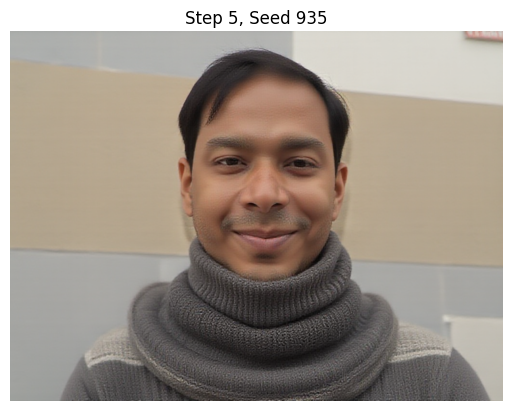

  0%|          | 0/10 [00:00<?, ?it/s]

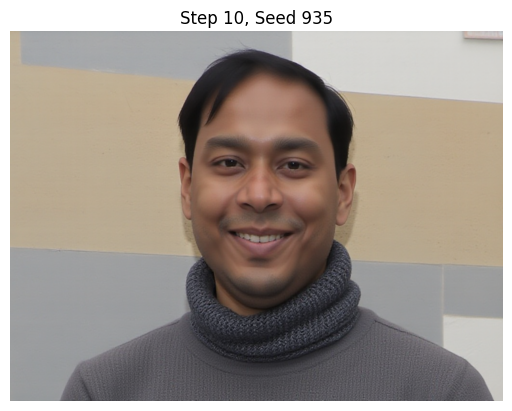

  0%|          | 0/15 [00:00<?, ?it/s]

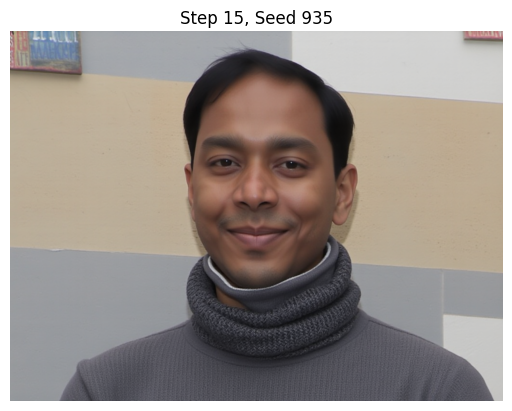

  0%|          | 0/20 [00:00<?, ?it/s]

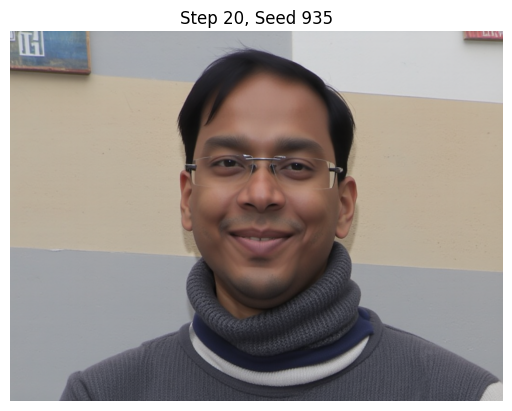

  0%|          | 0/25 [00:00<?, ?it/s]

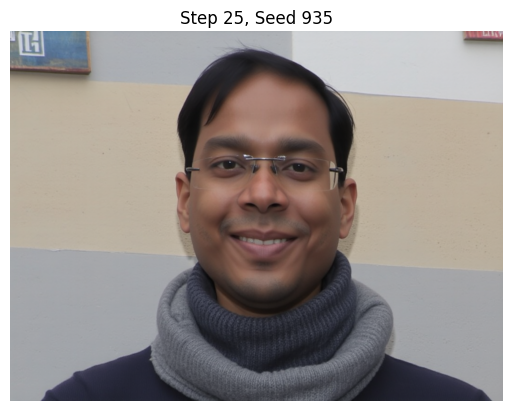

  0%|          | 0/30 [00:00<?, ?it/s]

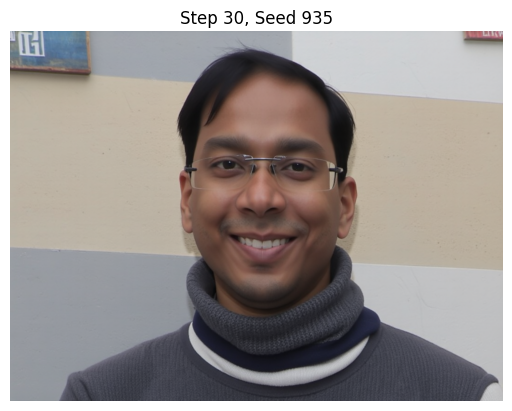

In [15]:
# add a random seed through a randoim interger generator
# Display image at every step inside the loop

import matplotlib.pyplot as plt
import random
seed = random.randint(1, 1000)

steps = [5, 10, 15, 20, 25, 30]
prompt = "a linkedin profile picture of smiling aks wearing a sweater and a muffler around his neck."
images = []
for n_steps in steps:

  images.append(generate_images(prompt, guidance_scale=4, n_steps=n_steps, seed=seed)[0])
  plt.imshow(images[-1])
  plt.axis("off")
  plt.title(f"Step {n_steps}, Seed {seed}")
  plt.show()